# <span style="color:#00BDFF">Interval selection search for pls sklearn</span>

This tutorial applies interval pls for regression.

A loop search is performed to tune the number of lv, the size of the interval and the direction of search

The interval selection is done to optimize the RMSECV value, the values are displayed in the output as the search goes. This can be silent with the argument verbose.

In [1]:

import sys
import datetime
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd



from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import GridSearchCV,cross_val_predict
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score



import modules.variable_selection as varsel


# Input data

In [2]:

data_url = "https://gitlab.com/vfonsecad/chemometrics_data/-/raw/main/data/nir_pharmaceutical_tablets/nir_shootout_2002_all.csv"
data_pd_raw = pd.read_csv(data_url, sep = ";", index_col = 0)




In [3]:
# model data

y_names = ['assay   '] # keeping it in list so that ycal is 2D for OSC preprocessing
cal_df = data_pd_raw[(data_pd_raw["instrument"] == "instrument_1") & (data_pd_raw["type"] == "calibration")]
test_df = data_pd_raw[(data_pd_raw["instrument"] == "instrument_1") & (data_pd_raw["type"] == "test")]

ycal = np.asarray(cal_df[y_names])
ytest = np.asarray(test_df[y_names])
xcal = np.asarray(cal_df.iloc[:,6:])
xtest = np.asarray(test_df.iloc[:,6:])

wv_range = np.arange(1,xcal.shape[1]+1) #no info about the wv range


In [4]:
plt.plot(wv_range, xcal[0].T, c = "blue", label = "cal")
plt.plot(wv_range, xcal.T, c = "blue")
plt.plot(wv_range, xtest[0].T, c = "red", label = "test")
plt.plot(wv_range, xtest.T, c = "red")
plt.xlabel("wv")
plt.ylabel("spectral value")
plt.title("spectral data")
plt.legend(loc = "upper left")
plt.grid()
plt.show()


# Variable selection

The tuning parameters to set here are the number of latent variables, the interval size and the direction of search.

Only forward and backward are available.

In [6]:
range_lv = [3,4,5]
range_interval_size = [5,10,20,30]
direction = ["forward", "backward"]
results_performance = []

In [9]:
for direct in direction:
    
    for isize in range_interval_size:
        
        for lv in range_lv:
            
            print("lv: {:d} - isize: {:d} - direction: {}".format(lv, isize, direct))
            
            intervals_selected = varsel.iplsr_univariate(xcal, ycal, chosen_lv=lv,
                                                         interval_size=isize, forward = direct == "forward", 
                                                         verbose = True)
            
            

            
            xcal_pls = xcal[:,intervals_selected]
            ycal_pls = ycal.copy()
               
                
            
            # fit model
            
            my_pls = PLSRegression(n_components = lv,scale=False)
            my_pls.fit(xcal_pls, ycal_pls)
            
            # cv
            
            n_splits_cv = 10
            pls_cv = KFold(n_splits=n_splits_cv, shuffle=True)
            ycal_cv = cross_val_predict(my_pls, xcal_pls, ycal_pls, cv = pls_cv)
            rmsecv = np.sqrt(mean_squared_error(ycal_pls, ycal_cv))            
            r2cv = np.power(np.corrcoef(ycal_pls.T,ycal_cv.T)[0,1],2)


            # deliver model

            B = my_pls.coef_
            beta = ycal_pls.mean(axis=0) - (xcal_pls.mean(axis=0).dot(B))
            
            
            ycal_pls_pred = xcal_pls.dot(B) + beta
            rmsec = np.sqrt(mean_squared_error(ycal_pls, ycal_pls_pred))            
            r2c = np.power(np.corrcoef(ycal_pls.T,ycal_pls_pred.T)[0,1],2)


            results = {}
            
            results["direction"] = direct
            results["lv"] = lv
            results["isize"] = isize
            results["rmsec"] = rmsec
            results["r2c"] = r2c
            results["rmsecv"] = rmsecv
            results["r2cv"] = r2cv

            
            results_performance.append(results)
            

print("done")



lv: 3 - isize: 5 - direction: forward
219.09316720165998
4.181471594744513
4.181471594744513
4.181471594744513
lv: 4 - isize: 5 - direction: forward
219.09316720165998
4.240644575947271
4.027256342717541
4.027256342717541
lv: 5 - isize: 5 - direction: forward
219.09316720165998
4.253195066526804
3.9419448398562067
3.9419448398562067
lv: 3 - isize: 10 - direction: forward
219.09316720165998
4.346644394278175
4.179993144658826
4.179993144658826
lv: 4 - isize: 10 - direction: forward
219.09316720165998
4.2977106092000765
3.977748653377676
3.977748653377676
lv: 5 - isize: 10 - direction: forward
219.09316720165998
4.419674676033374
3.8994303880502073
3.8994303880502073
lv: 3 - isize: 20 - direction: forward
219.09316720165998
4.468441403830982
4.401628377567051
4.364523595803558
lv: 4 - isize: 20 - direction: forward
219.09316720165998
4.261190984364758
3.912613440873745
3.912613440873745
lv: 5 - isize: 20 - direction: forward
219.09316720165998
4.332060682134595
4.051667102114054
3.871089

In [10]:
# apply var selection for plsr


pd_performance = pd.DataFrame(results_performance)
pd_performance.sort_values("r2cv")



direction  lv  isize     rmsec       r2c    rmsecv      r2cv
15  backward   3      5  5.673249  0.932949  5.923317  0.926989
18  backward   3     10  5.263452  0.942286  5.582776  0.935093
21  backward   3     20  4.908391  0.949810  5.112410  0.945568
24  backward   3     30  4.904428  0.949891  5.061195  0.946659
19  backward   4     10  4.722836  0.953533  5.009045  0.947730
23  backward   5     20  4.350311  0.960574  4.992945  0.948086
22  backward   4     20  4.794108  0.952120  4.981141  0.948355
20  backward   5     10  4.514957  0.957533  4.941816  0.949142
17  backward   5      5  4.522787  0.957386  4.931205  0.949343
16  backward   4      5  4.665112  0.954662  4.902363  0.949976
25  backward   4     30  4.658389  0.954792  4.886111  0.950268
12   forward   3     30  4.709361  0.953797  4.826245  0.951478
9    forward   3     20  4.612076  0.955687  4.792658  0.952153
26  backward   5     30  4.512478  0.957580  4.767219  0.952665
6    forward   3     10  4.444890  0.958841  4.648118  0.955004
13   forward   4     30  4.417742  0.959342  4.634591  0.955277
0    forward   3      5  4.358788  0.960420  4.532956  0.957240
4    forward   4      5  4.279649  0.961844  4.529976  0.957254
1    forward   4      5  4.279649  0.961844  4.516550  0.957521
3    forward   3      5  4.358788  0.960420  4.495328  0.957907
14   forward   5     30  4.180005  0.963600  4.471807  0.958374
5    forward   5      5  4.101156  0.964961  4.424644  0.959274
10   forward   4     20  4.222666  0.962854  4.406972  0.959544
11   forward   5     20  4.190777  0.963413  4.390763  0.959841
7    forward   4     10  4.221419  0.962876  4.381005  0.960023
2    forward   5      5  4.101156  0.964961  4.337751  0.960822
8    forward   5     10  4.119700  0.964643  4.318342  0.961187

# Chosen variable selection

In [11]:
# apply var selection for plsr

intervals_selected = varsel.iplsr_univariate(xcal, ycal, chosen_lv = 4,interval_size = 20, forward = True, verbose = True)

219.09316720165998
4.261190984364758
3.912613440873745
3.912613440873745


In [19]:
# visualize data

plt.plot(wv_range,xcal[0], c = "blue", label = "entire range")
plt.plot(wv_range,xcal.T, c = "blue")

plt.plot(wv_range[intervals_selected],xcal[0,intervals_selected],'o', c = "yellow",alpha = 0.5, label = "interval selected")
plt.plot(wv_range[intervals_selected],xcal[:,intervals_selected].T,'o', c = "yellow", alpha = 1)

plt.xlabel("wv")
plt.ylabel("spectral value")
plt.title("spectral data - interval selection")
plt.legend(loc = "upper left")
plt.grid()
plt.savefig("./figures/intervals.svg")
plt.show()

# PLSR model

In [15]:
# model data for preproc search

wv_range_final = wv_range[intervals_selected]

xcal_pls = xcal[:,intervals_selected]
ycal_pls = ycal.copy()

xtest_pls = xtest[:,intervals_selected]
ytest_pls = ytest.copy()

print(xcal_pls.shape, xtest_pls.shape)
print(ycal_pls.shape, ytest_pls.shape)


(155, 40) (460, 40)
(155, 1) (460, 1)


In [16]:
# choose model

chosen_lv = 4

my_pls = PLSRegression(n_components = chosen_lv,scale=False)
my_pls.fit(xcal_pls, ycal_pls)

# deliver model

B = my_pls.coef_
beta = ycal_pls.mean(axis=0) - (xcal_pls.mean(axis=0).dot(B))



In [17]:
# use model


ycal_pls_pred = xcal_pls.dot(B) + beta
rmsec = np.sqrt(mean_squared_error(ycal_pls, ycal_pls_pred))
r2c = np.power(np.corrcoef(ycal_pls.T,ycal_pls_pred.T)[0,1],2)


ytest_pls_pred = xtest_pls.dot(B) + beta
rmsep = np.sqrt(mean_squared_error(ytest_pls, ytest_pls_pred))
r2p = np.power(np.corrcoef(ytest_pls.T,ytest_pls_pred.T)[0,1],2)



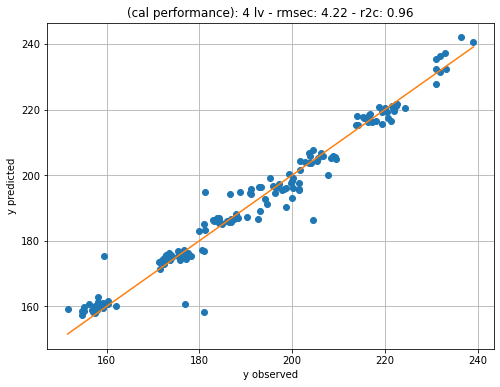

In [18]:
# model performance

cal_title = "(cal performance): {:d} lv - rmsec: {:.2f} - r2c: {:.2f}".format(chosen_lv, rmsec, r2c) 

plt.subplots(figsize = (8,6))
plt.plot(ycal_pls,ycal_pls_pred,'o')
plt.plot([np.amin(ycal_pls),np.amax(ycal_pls)],[np.amin(ycal_pls),np.amax(ycal_pls)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(cal_title) 
plt.show()

test_title = "(test performance): {:d} lv - rmsep: {:.2f} - r2p: {:.2f}".format(chosen_lv, rmsep, r2p) 

plt.subplots(figsize = (8,6))
plt.plot(ytest_pls,ytest_pls_pred,'o')
plt.plot([np.amin(ytest_pls),np.amax(ytest_pls)],[np.amin(ytest_pls),np.amax(ytest_pls)])
plt.grid()
plt.xlabel("y observed")
plt.ylabel("y predicted")
plt.title(test_title)
plt.show()

